# Define the business goal

Build a model that can predict tomorrow's temperature as precisely as possible.

In [1]:
# base packages and dictionaries
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
#from statsmodels.tsa.ar_model import AutoReg
#from cleanup import clean_data
#from engineer import feature_engineer

import seaborn as sns
import matplotlib.pyplot as plt


# some aesthetic setting for plotting for the rest of the notebook
sns.set()
plt.rcParams['figure.figsize'] = (20, 9)

import warnings
warnings.filterwarnings('ignore')

# Data processes

## Get the data

In [2]:
# Berlin-Tempelhof mean temperature data from www.ecad.eu is used 
df = pd.read_csv('../data/TG_STAID002759.txt', index_col=1, parse_dates=True,header=14)

In [3]:
df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [4]:
df.describe().round(1)

,SOUID,TG,Q_TG
count,53416.0,53416.0,53416.0
mean,119348.9,56.9,0.0
std,8023.7,615.3,0.5
min,111448.0,-9999.0,0.0
25%,111448.0,33.0,0.0
50%,111448.0,93.0,0.0
75%,127488.0,157.0,0.0
max,128124.0,305.0,9.0


## Plot the data

In [5]:
def plot_data(df,column, title='Mean Temperature of Years'):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.groupby(['year','month'])[f'{column}'].mean().plot()
    plt.title(title)
    plt.ylabel('Temperature ˚C')
    plt.xlabel('Date')
    plt.show()
    


## Clean the Data

In [6]:
# Check whether the column contains any missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53416 entries, 1876-01-01 to 2022-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0    SOUID  53416 non-null  int64
 1      TG   53416 non-null  int64
 2    Q_TG   53416 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


In [7]:
df.isnull().sum()

 SOUID    0
   TG     0
 Q_TG     0
dtype: int64

In [8]:
def clean_data(df):
    
    # For the Mean_Temp columns, missing value code is -9999
    # For the Quality_Code_Mean_Temp columns, missing value code is 9
    # I replace the missing value codes to NaN

    df.columns=df.columns.str.replace(' ', '')
    df['TG'] = df['TG'].replace(-9999,np.nan)
    df['Q_TG'] = df['Q_TG'].replace(9,np.nan)
   
    # Fill the missing values to use interpolate(method=linear)
    # Add a new column and calculate the actual temperature multiply by 0.1 celcius

    df['mean_temp'] = df['TG'].interpolate()*0.1
    
    # Fill the missing values to use fillna(method='ffill')
    
    df['Q_mean_temp'] = df['Q_TG'].fillna(method='ffill')
    
    # Drop the unneccessary columns
    
    df.drop(['TG', 'Q_TG', 'SOUID'], axis = 1, inplace = True)
    
    
    return df

In [9]:
df=clean_data(df)

In [10]:
df.isna().sum()

mean_temp      0
Q_mean_temp    0
dtype: int64

In [11]:
# Extract the year and month
df['year']  = df.index.year
df['month'] = df.index.month

In [12]:
df.head()

,mean_temp,Q_mean_temp,year,month
DATE,,,,
1876-01-01,2.2,0.0,1876,1
1876-01-02,2.5,0.0,1876,1
1876-01-03,0.3,0.0,1876,1
1876-01-04,-5.8,0.0,1876,1
1876-01-05,-9.8,0.0,1876,1


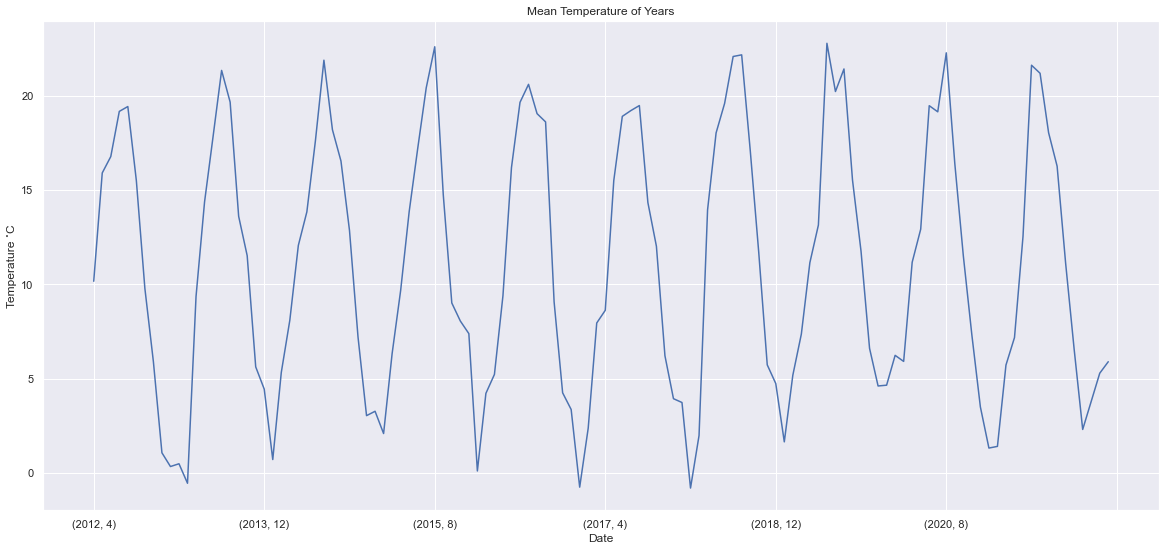

In [13]:
# Last 10 years ploted
plot_data(df.tail(3650),'mean_temp')

## Extract the timestep and add the seasonal dummies for the whole dataset

In [14]:
# Extract the time step
df['timestep'] = range(len(df))
df.head()

,mean_temp,Q_mean_temp,year,month,timestep
DATE,,,,,
1876-01-01,2.2,0.0,1876,1,0
1876-01-02,2.5,0.0,1876,1,1
1876-01-03,0.3,0.0,1876,1,2
1876-01-04,-5.8,0.0,1876,1,3
1876-01-05,-9.8,0.0,1876,1,4


In [15]:
# One-Hot-Encoding the month of year
seasonal_dummies = pd.get_dummies(df.index.month,
                                prefix='month',
                                drop_first=True).set_index(df.index)

In [16]:
seasonal_dummies.head()

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# join the dummies with the data frame
df = df.join(seasonal_dummies)

In [18]:
df.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,
1876-01-01,2.2,0.0,1876,1,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,0.0,1876,1,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,0.0,1876,1,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,0.0,1876,1,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,0.0,1876,1,4,0,0,0,0,0,0,0,0,0,0,0


## Train-test split

In [19]:
# Data is used after year 1970 for the model, approx more than 50 years
df_train = df[df['year']>=1970].copy()[:-365]
df_test = df[df['year']>=1970].copy()[-365:]


In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18718 entries, 1970-01-01 to 2021-03-31
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mean_temp    18718 non-null  float64
 1   Q_mean_temp  18718 non-null  float64
 2   year         18718 non-null  int64  
 3   month        18718 non-null  int64  
 4   timestep     18718 non-null  int64  
 5   month_2      18718 non-null  uint8  
 6   month_3      18718 non-null  uint8  
 7   month_4      18718 non-null  uint8  
 8   month_5      18718 non-null  uint8  
 9   month_6      18718 non-null  uint8  
 10  month_7      18718 non-null  uint8  
 11  month_8      18718 non-null  uint8  
 12  month_9      18718 non-null  uint8  
 13  month_10     18718 non-null  uint8  
 14  month_11     18718 non-null  uint8  
 15  month_12     18718 non-null  uint8  
dtypes: float64(2), int64(3), uint8(11)
memory usage: 1.1 MB


In [21]:
df_train.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,
1970-01-01,-12.8,0.0,1970,1,34333,0,0,0,0,0,0,0,0,0,0,0
1970-01-02,-4.9,0.0,1970,1,34334,0,0,0,0,0,0,0,0,0,0,0
1970-01-03,-1.4,0.0,1970,1,34335,0,0,0,0,0,0,0,0,0,0,0
1970-01-04,-4.4,0.0,1970,1,34336,0,0,0,0,0,0,0,0,0,0,0
1970-01-05,-3.0,0.0,1970,1,34337,0,0,0,0,0,0,0,0,0,0,0


In [22]:
# Change & fix the time step for train data
df_train['timestep'] = range(len(df_train))
df_train.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,
1970-01-01,-12.8,0.0,1970,1,0,0,0,0,0,0,0,0,0,0,0,0
1970-01-02,-4.9,0.0,1970,1,1,0,0,0,0,0,0,0,0,0,0,0
1970-01-03,-1.4,0.0,1970,1,2,0,0,0,0,0,0,0,0,0,0,0
1970-01-04,-4.4,0.0,1970,1,3,0,0,0,0,0,0,0,0,0,0,0
1970-01-05,-3.0,0.0,1970,1,4,0,0,0,0,0,0,0,0,0,0,0


# Modeling

## Model the Trend

### Linear trend

In [23]:
# Define X & y
X_t = df_train[['timestep']]
y_t = df_train ['mean_temp']

In [24]:
# Instantiate  Linear Regression
m_t = LinearRegression()

In [25]:
# Fit the model on X_t, y_t
m_t.fit(X_t,y_t)

LinearRegression()

In [26]:
# And the predictions for trend
df_train['trend'] = m_t.predict(X_t)

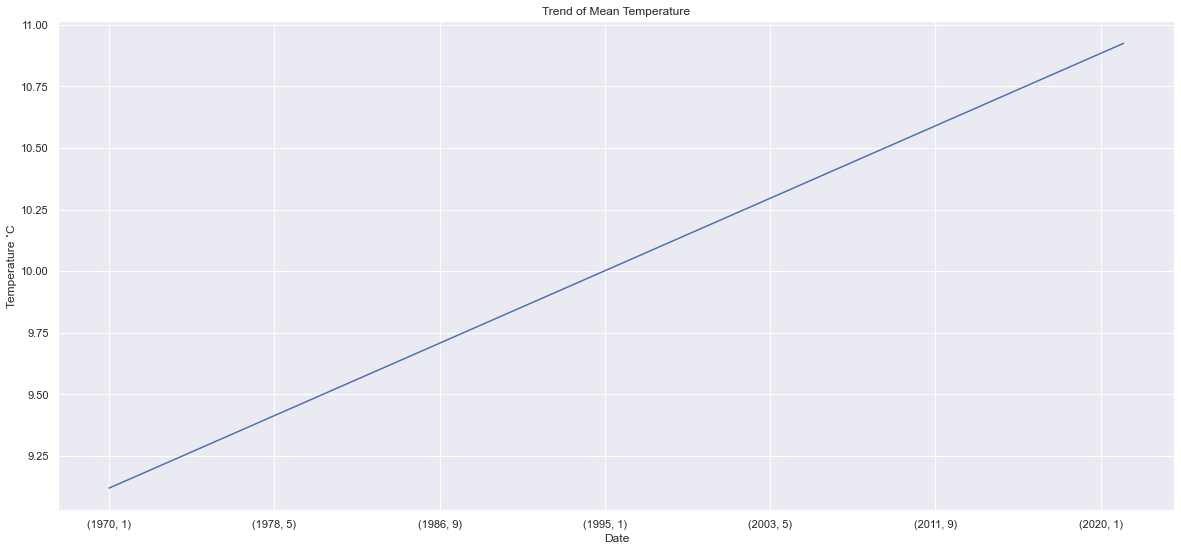

In [27]:
plot_data(df_train, 'trend', title='Trend of Mean Temperature')

<AxesSubplot:xlabel='year,month'>

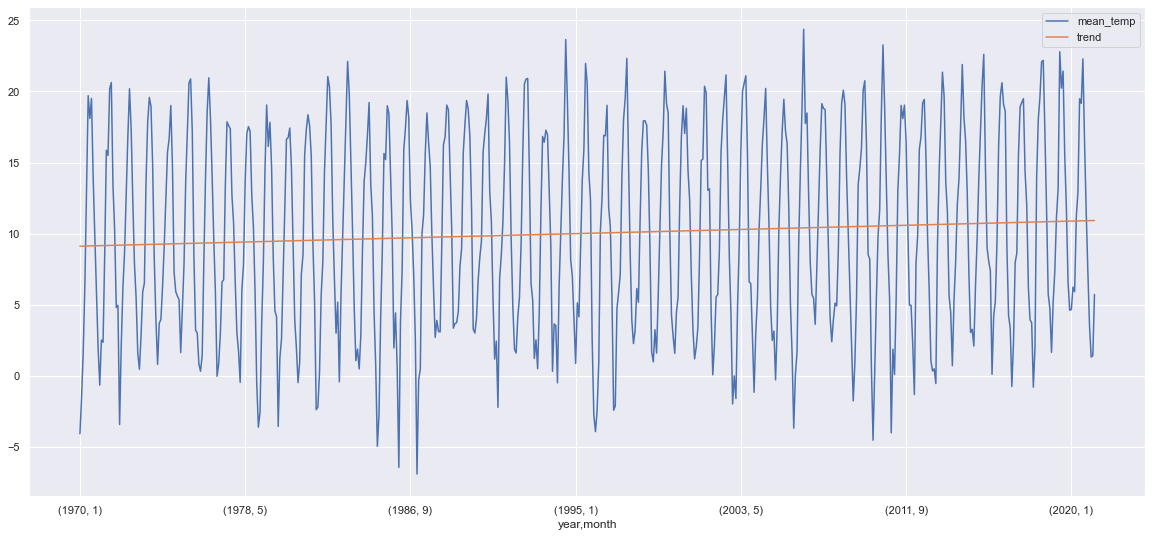

In [28]:
df_train.groupby(['year','month'])['mean_temp','trend'].mean().plot()


<AxesSubplot:xlabel='year,month'>

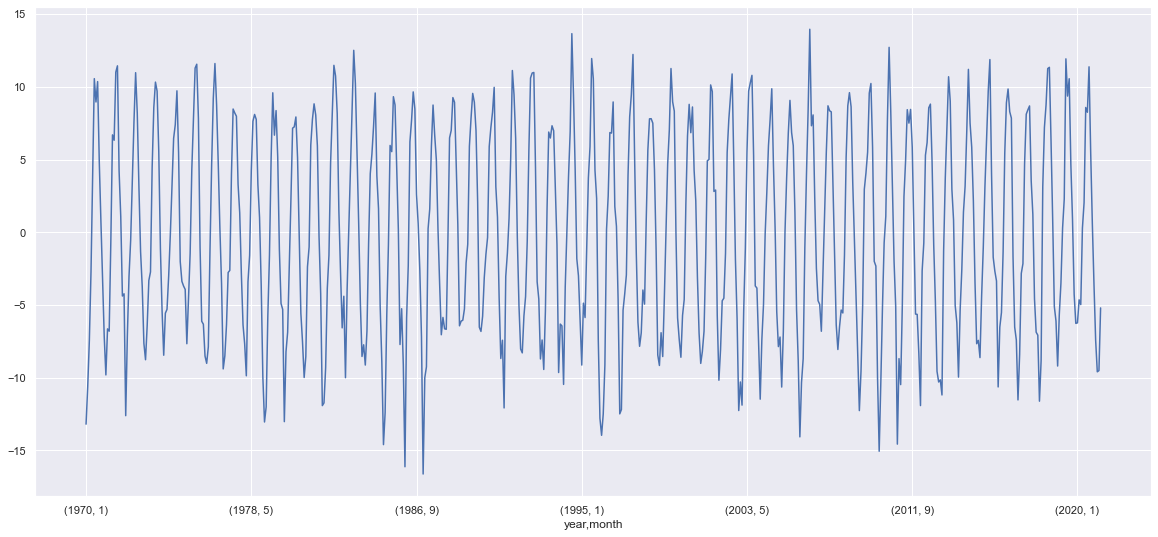

In [29]:
df_train['wo_trend'] = df_train['mean_temp'] - df_train['trend']
df_train.groupby(['year','month'])['wo_trend'].mean().plot()

### Polynomial trend

In [30]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# define a degree 2 for the polinomial
DEGREE = 2

# Instantiate the transformation 
poly = PolynomialFeatures(degree=DEGREE,include_bias=False)


In [31]:
# Fit & transform the X
X_poly= poly.fit_transform(X_t)


In [32]:
# Instantiate  Linear Regression
m_poly = LinearRegression()

# Fit the model on X
m_poly.fit(X_poly, y_t)

# And the predictions for polynomial trend
df_train['trend_poly']=m_poly.predict(X_poly)

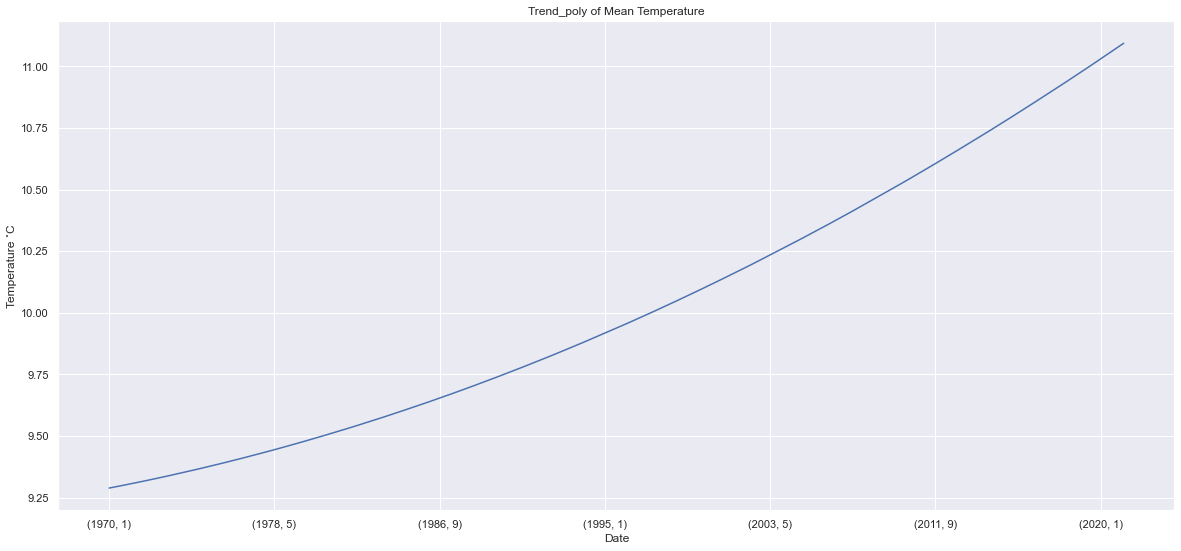

In [33]:
plot_data(df_train,'trend_poly', title='Trend_poly of Mean Temperature')

Text(0.5, 1.0, 'Mean Temperature of Years')

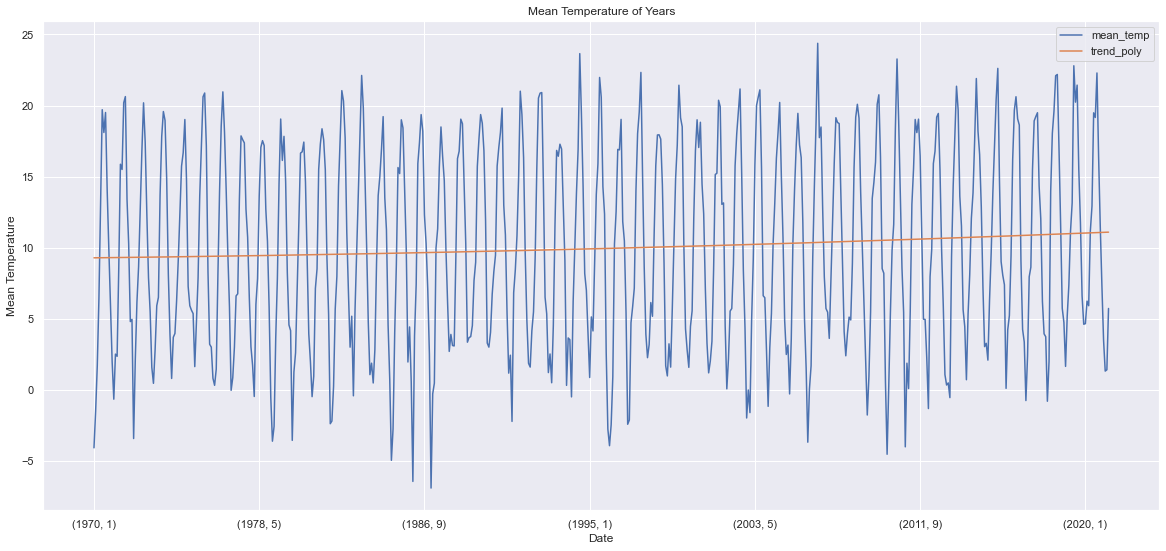

In [34]:
df_train.groupby(['year', 'month'])['mean_temp','trend_poly'].mean().plot()
plt.ylabel('Mean Temperature')
plt.xlabel('Date')
plt.title('Mean Temperature of Years')

<AxesSubplot:xlabel='year'>

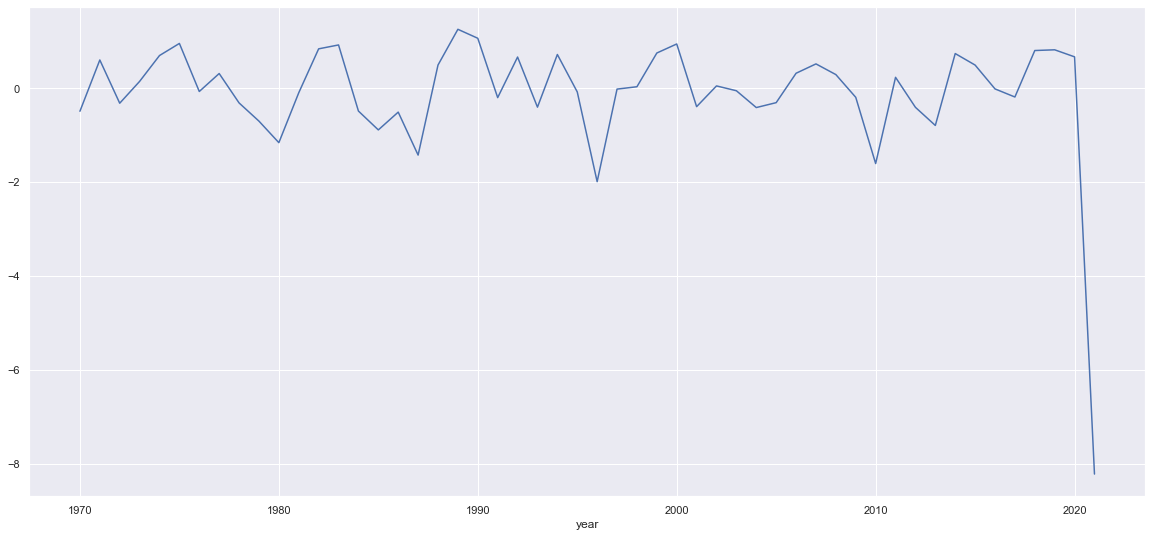

In [35]:
df_train['wo_trend_poly'] = df_train['mean_temp']-df_train['trend_poly']
df_train.groupby(['year'])['wo_trend_poly'].mean().plot()

In [36]:
round(m_poly.score(X_poly,y_t),4), round( m_t.score(X_t,y_t), 4)

(0.0045, 0.0044)

### Model the seasonality

In [37]:
# Define X and y
X_ts = df_train.drop(['mean_temp', 'Q_mean_temp','year', 'month', 'trend', 'wo_trend', 'trend_poly', 'wo_trend_poly'],axis = 1)
y_ts = df_train['mean_temp']

In [38]:
m_ts = LinearRegression()
m_ts.fit(X_ts,y_ts)

# Create a model with trend and seasonality

df_train['trend_seasonality']=m_ts.predict(X_ts)
df_train.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,...,month_8,month_9,month_10,month_11,month_12,trend,wo_trend,trend_poly,wo_trend_poly,trend_seasonality
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-01,-12.8,0.0,1970,1,0,0,0,0,0,0,...,0,0,0,0,0,9.118123,-21.918123,9.287719,-22.087719,-0.204274
1970-01-02,-4.9,0.0,1970,1,1,0,0,0,0,0,...,0,0,0,0,0,9.118220,-14.018220,9.287761,-14.187761,-0.204171
1970-01-03,-1.4,0.0,1970,1,2,0,0,0,0,0,...,0,0,0,0,0,9.118316,-10.518316,9.287803,-10.687803,-0.204068
1970-01-04,-4.4,0.0,1970,1,3,0,0,0,0,0,...,0,0,0,0,0,9.118413,-13.518413,9.287845,-13.687845,-0.203965
1970-01-05,-3.0,0.0,1970,1,4,0,0,0,0,0,...,0,0,0,0,0,9.118510,-12.118510,9.287888,-12.287888,-0.203862


Text(0.5, 0, 'Date')

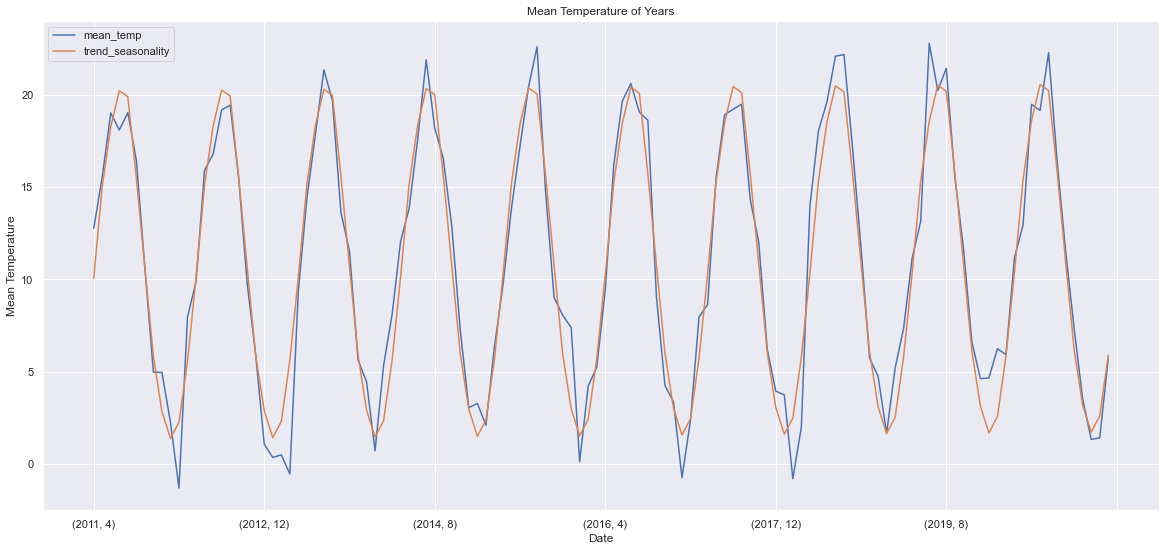

In [39]:
# Repeating short-term cycle is occured in the series
df_train.tail(3650).groupby(['year', 'month'])['mean_temp', 'trend_seasonality'].mean().plot()

plt.title("Mean Temperature of Years")
plt.ylabel('Mean Temperature')
plt.xlabel('Date')

### Extracting and saving the remainder

In [40]:
df_train['remainder'] = df_train['mean_temp'] - df_train['trend_seasonality']

<AxesSubplot:xlabel='year,month'>

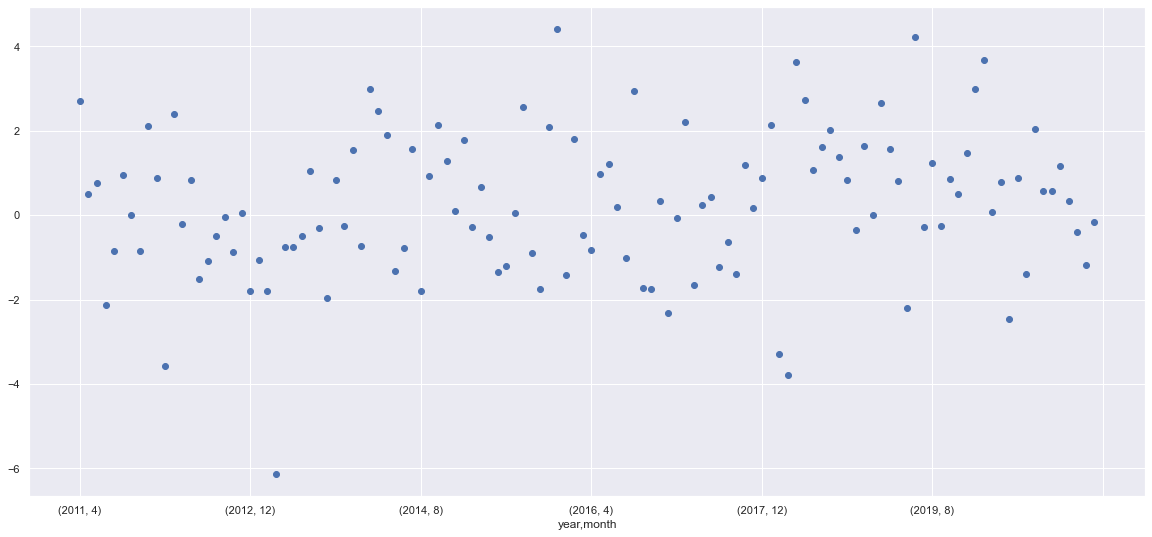

In [41]:
df_train.tail(3650).groupby(['year', 'month'])['remainder'].mean().plot(style='o')

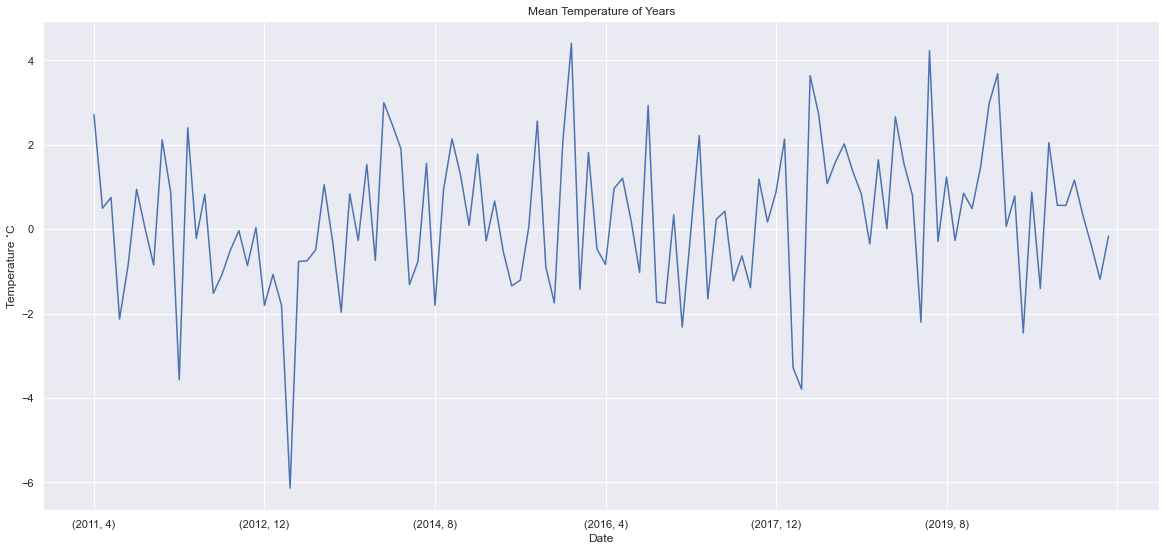

In [42]:
# what's left of the time series data after removing its trend, cycle, and seasonal components
plot_data(df_train.tail(3650), 'remainder')

In [43]:
# write remainder data into a csv file
df_train['remainder'].to_csv('df_train_remainder.csv')

## Closing remarks

### Automatic analysis / decomposition

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [45]:
sd = seasonal_decompose(df_train.tail(730)['mean_temp'], model='additive')

# optional parameter: model="multiplicative" # this assumes trend * seasonality instead of trend + seasonality

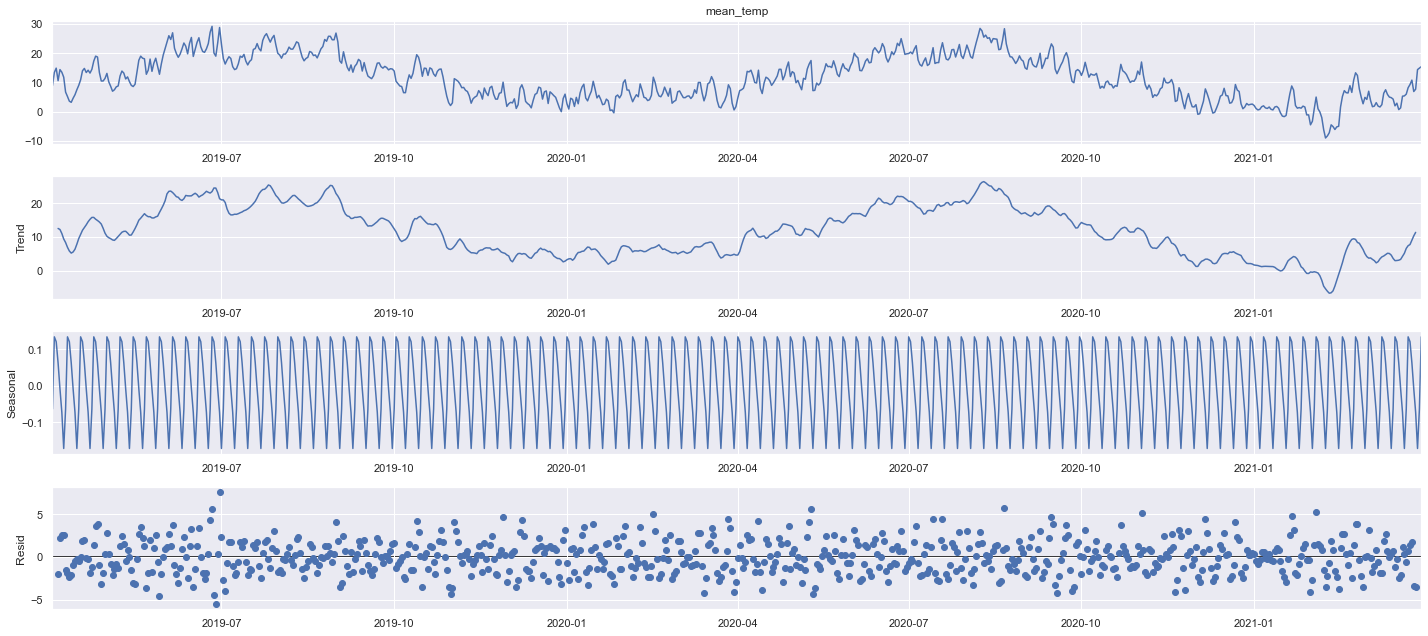

In [46]:
sd.plot()
None

<AxesSubplot:xlabel='    DATE'>

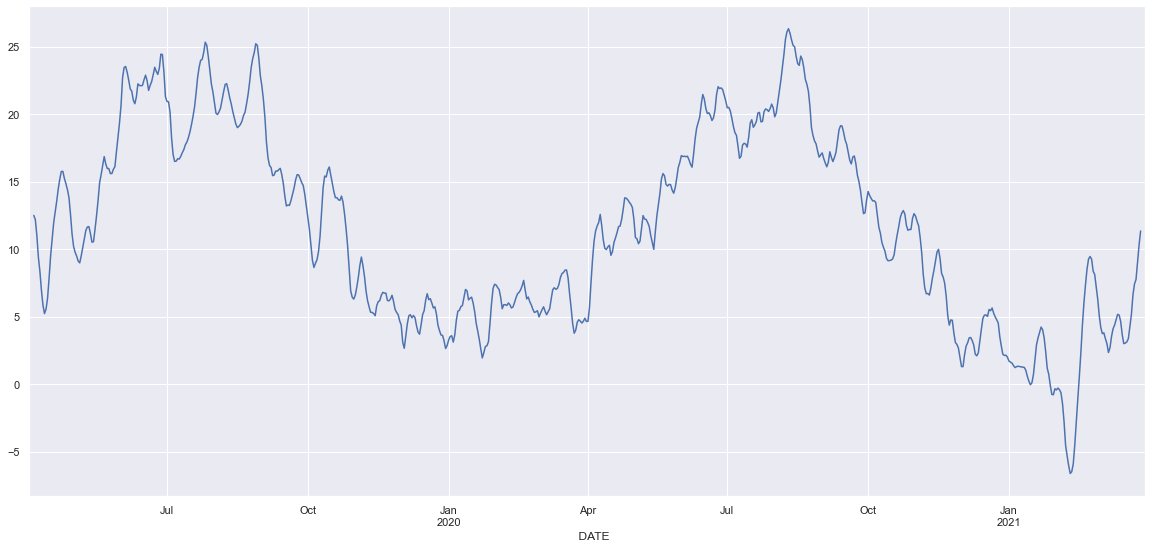

In [47]:
sd.trend.plot()

<AxesSubplot:xlabel='    DATE'>

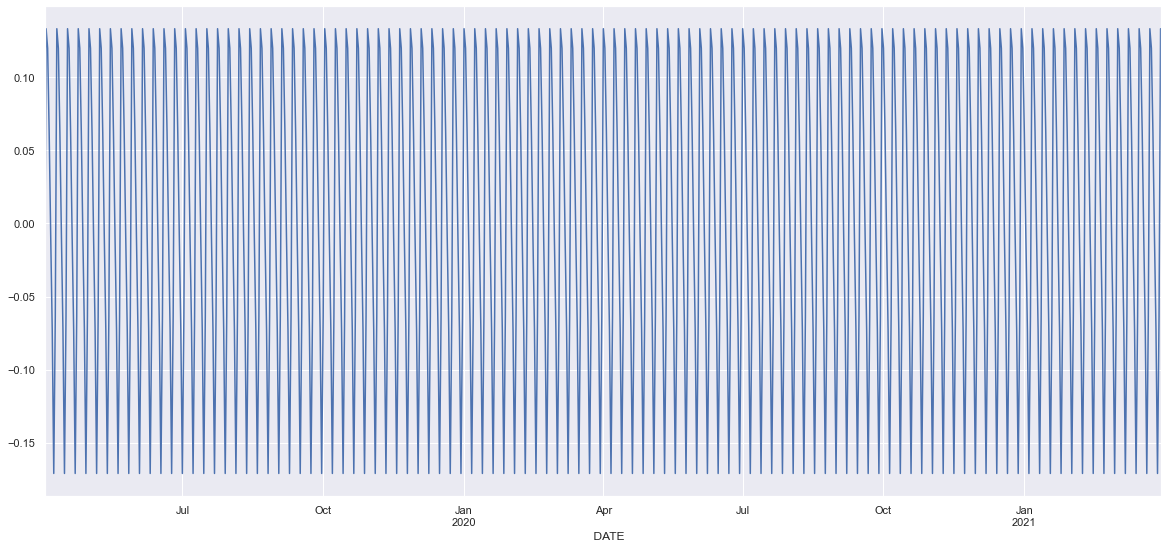

In [48]:
sd.seasonal.plot()

<AxesSubplot:xlabel='    DATE'>

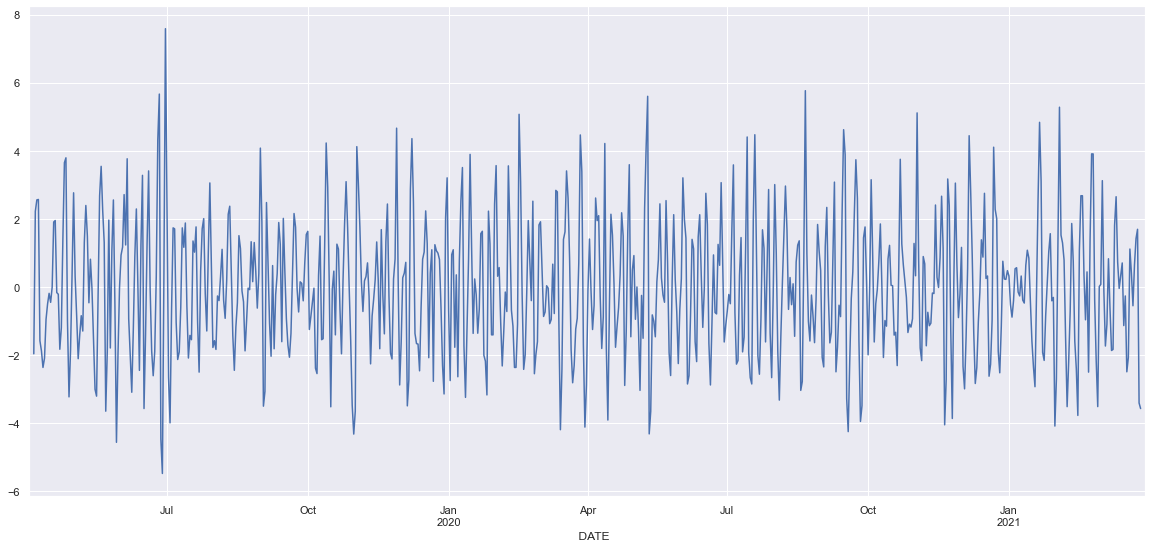

In [49]:
sd.resid.plot()

## Inspect the remainder to decide how many lags to include

In [50]:
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

### Load the remainder data

In [51]:
remainder = pd.read_csv('../own code/df_train_remainder.csv',index_col=0)
remainder.head()

,remainder
DATE,
1970-01-01,-12.595726
1970-01-02,-4.695829
1970-01-03,-1.195932
1970-01-04,-4.196035
1970-01-05,-2.796138


### Create a time-lagged input feature: lag1

In [52]:
remainder['lag1']=remainder['remainder'].shift(1)
remainder.head()

,remainder,lag1
DATE,,
1970-01-01,-12.595726,NaN
1970-01-02,-4.695829,-12.595726
1970-01-03,-1.195932,-4.695829
1970-01-04,-4.196035,-1.195932
1970-01-05,-2.796138,-4.196035


### Inspect correlations

In [53]:
remainder.corr()

,remainder,lag1
remainder,1.000000,0.805864
lag1,0.805864,1.000000


### Plot remainder against lag1

<AxesSubplot:xlabel='lag1', ylabel='remainder'>

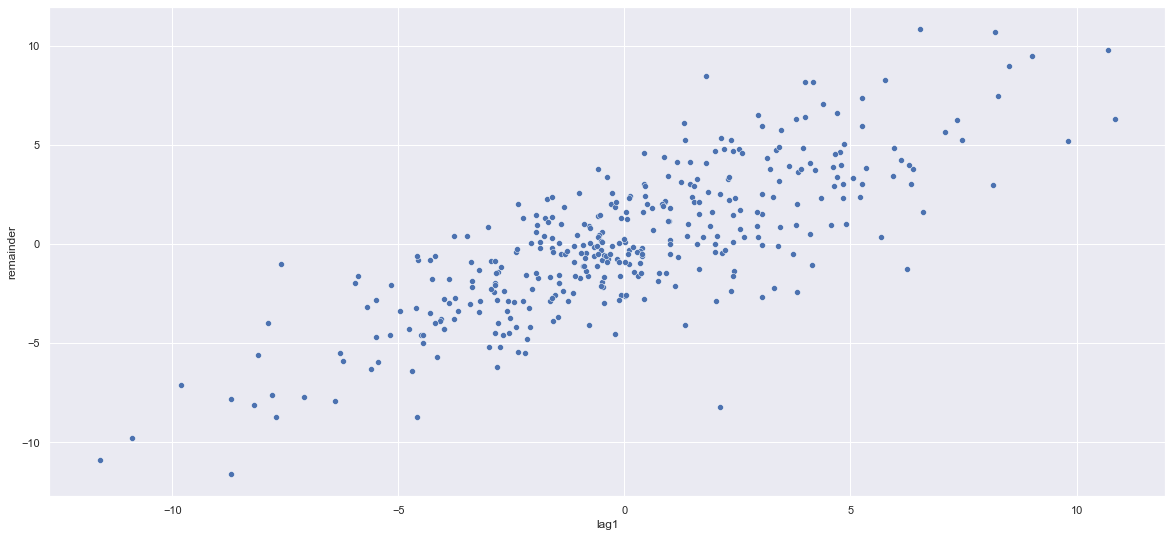

In [54]:
# last year data used
sns.scatterplot(x = 'lag1', y = 'remainder', data=remainder.tail(365))

### Run an Autoregression (Linear Regression) of lag1 on the remainder

In [55]:
# Drop missing values
remainder.dropna(inplace=True)
remainder.head()

,remainder,lag1
DATE,,
1970-01-02,-4.695829,-12.595726
1970-01-03,-1.195932,-4.695829
1970-01-04,-4.196035,-1.195932
1970-01-05,-2.796138,-4.196035
1970-01-06,-4.496241,-2.796138


In [56]:
# Assign X and y
X_ar = remainder[['lag1']]
y_ar = remainder['remainder']

In [57]:
# Create and fit the model
m_ar = LinearRegression()
m_ar.fit(X_ar, y_ar)

LinearRegression()

In [58]:
# Create predictions
remainder['predictions_ar1'] = m_ar.predict(X_ar)
remainder.head()

,remainder,lag1,predictions_ar1
DATE,,,
1970-01-02,-4.695829,-12.595726,-10.148154
1970-01-03,-1.195932,-4.695829,-3.782668
1970-01-04,-4.196035,-1.195932,-0.962562
1970-01-05,-2.796138,-4.196035,-3.379950
1970-01-06,-4.496241,-2.796138,-2.251957


<AxesSubplot:xlabel='    DATE'>

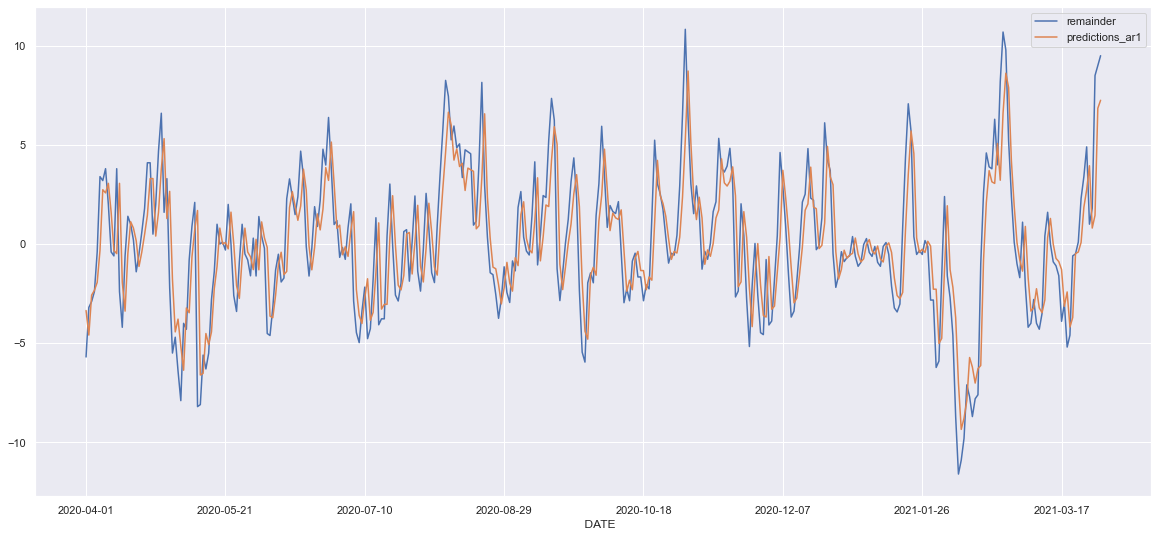

In [59]:
remainder[['remainder', 'predictions_ar1']].tail(365).plot()

### Autocorrelation

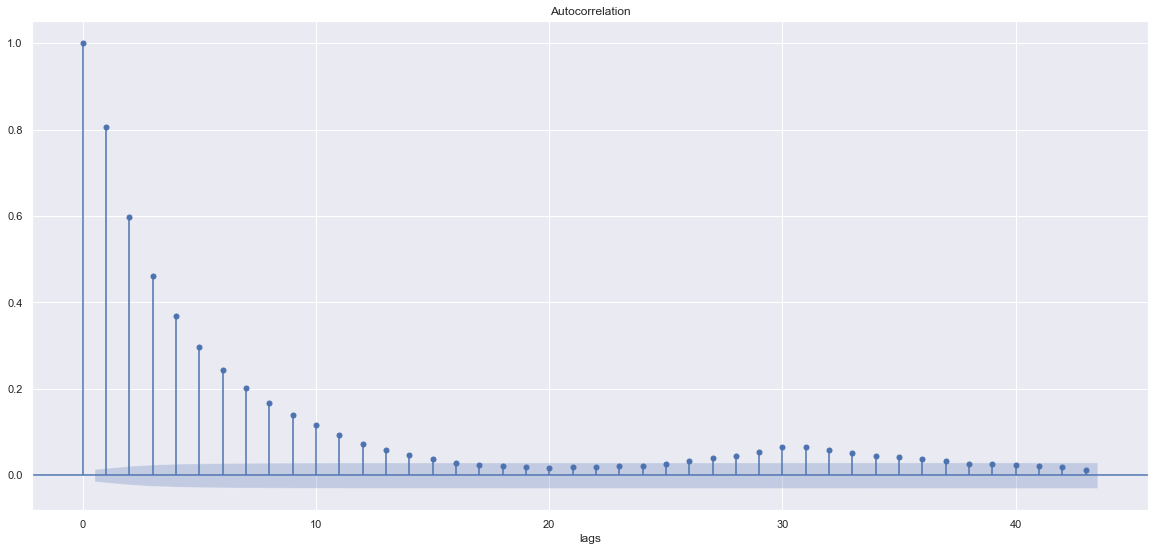

In [60]:
plot_acf(remainder['remainder'])
plt.xlabel('lags');

### Determine Partial Autocorrelation - How many lags to use?

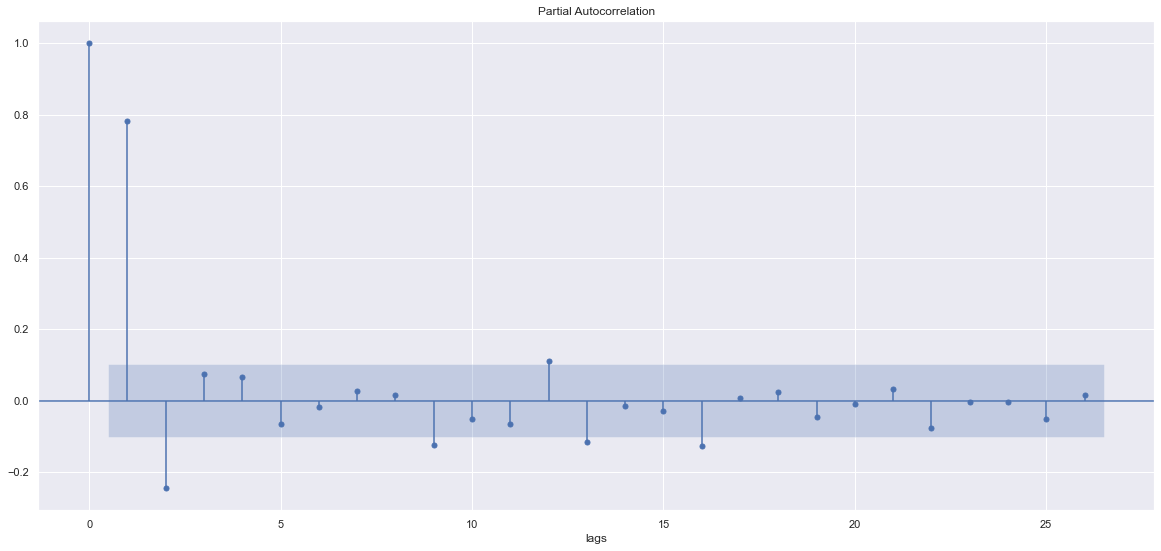

In [61]:
plot_pacf(remainder['remainder'].tail(365))
plt.xlabel('lags');

## Full Model - Add the lags of the remainder to the training data

In [62]:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train.dropna(inplace = True)
df_train.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,...,month_10,month_11,month_12,trend,wo_trend,trend_poly,wo_trend_poly,trend_seasonality,remainder,lag1
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-02,-4.9,0.0,1970,1,1,0,0,0,0,0,...,0,0,0,9.118220,-14.018220,9.287761,-14.187761,-0.204171,-4.695829,-12.595726
1970-01-03,-1.4,0.0,1970,1,2,0,0,0,0,0,...,0,0,0,9.118316,-10.518316,9.287803,-10.687803,-0.204068,-1.195932,-4.695829
1970-01-04,-4.4,0.0,1970,1,3,0,0,0,0,0,...,0,0,0,9.118413,-13.518413,9.287845,-13.687845,-0.203965,-4.196035,-1.195932
1970-01-05,-3.0,0.0,1970,1,4,0,0,0,0,0,...,0,0,0,9.118510,-12.118510,9.287888,-12.287888,-0.203862,-2.796138,-4.196035
1970-01-06,-4.7,0.0,1970,1,5,0,0,0,0,0,...,0,0,0,9.118606,-13.818606,9.287930,-13.987930,-0.203759,-4.496241,-2.796138


In [63]:
# Define X and y
X_full = df_train.drop([ 'year', 'month', 'mean_temp', 'Q_mean_temp', 'trend', 'wo_trend', 'trend_poly', 'wo_trend_poly', 'trend_seasonality', 'remainder'],axis = 1)
y_full = df_train['mean_temp']

In [64]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [65]:
# Create a new predictions column
df_train['predictions_full_model'] = m_full.predict(X_full)

## Plot the predictions_full_model vs mean_temp for the training data

<AxesSubplot:xlabel='    DATE'>

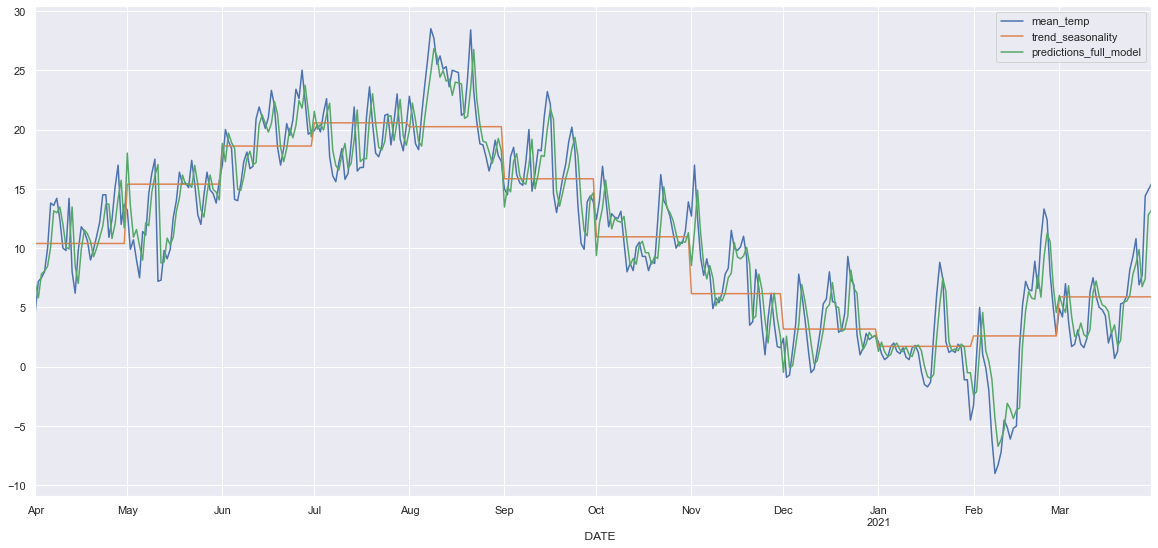

In [66]:
df_train[['mean_temp', 'trend_seasonality', 'predictions_full_model']].tail(365).plot()

In [67]:
df_train.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,...,month_11,month_12,trend,wo_trend,trend_poly,wo_trend_poly,trend_seasonality,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-02,-4.9,0.0,1970,1,1,0,0,0,0,0,...,0,0,9.118220,-14.018220,9.287761,-14.187761,-0.204171,-4.695829,-12.595726,-10.308888
1970-01-03,-1.4,0.0,1970,1,2,0,0,0,0,0,...,0,0,9.118316,-10.518316,9.287803,-10.687803,-0.204068,-1.195932,-4.695829,-3.942538
1970-01-04,-4.4,0.0,1970,1,3,0,0,0,0,0,...,0,0,9.118413,-13.518413,9.287845,-13.687845,-0.203965,-4.196035,-1.195932,-1.121992
1970-01-05,-3.0,0.0,1970,1,4,0,0,0,0,0,...,0,0,9.118510,-12.118510,9.287888,-12.287888,-0.203862,-2.796138,-4.196035,-3.539566
1970-01-06,-4.7,0.0,1970,1,5,0,0,0,0,0,...,0,0,9.118606,-13.818606,9.287930,-13.987930,-0.203759,-4.496241,-2.796138,-2.411336


In [68]:
# Coefficients of the AR equation's terms:
pd.DataFrame(m_full.coef_.reshape(1,13), columns=X_full.columns)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,0.000103,0.872299,4.166243,8.667261,13.616147,16.840776,18.832923,18.419776,14.082112,9.190777,4.407444,1.447173,0.805865


In [69]:
print(f'The score of seasonality model is {round(m_ts.score(X_ts,y_ts),2)}')
print(f'The score of full model with lag1 is {round(m_full.score(X_full,y_full),2)}')

The score of seasonality model is 0.75
The score of full model with lag1 is 0.91


## Evaluate our model - Cross Validation

In [70]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [71]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 3119 3120 3121]
The validation data for the 1th iteration are the observations steps
    [3122 3123 3124 ... 6238 6239 6240]


The training data for the 2th iteration are the observations steps 
    [   0    1    2 ... 6238 6239 6240]
The validation data for the 2th iteration are the observations steps
    [6241 6242 6243 ... 9357 9358 9359]


The training data for the 3th iteration are the observations steps 
    [   0    1    2 ... 9357 9358 9359]
The validation data for the 3th iteration are the observations steps
    [ 9360  9361  9362 ... 12476 12477 12478]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 12476 12477 12478]
The validation data for the 4th iteration are the observations steps
    [12479 12480 12481 ... 15595 15596 15597]


The training data for the 5th iteration are the observations steps 
    [    0     1     2 ... 15595 15596

In [72]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [73]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.91237128, 0.89329492, 0.9155524 , 0.91894261, 0.91589311])

In [74]:
round(result.mean(),2)

0.91

## Augmented Dickey - Fuller test

In [75]:
import statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa import stattools

In [76]:
df_train['residual'] = df_train['mean_temp'] - df_train['predictions_full_model']

In [77]:
df_train.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,...,month_12,trend,wo_trend,trend_poly,wo_trend_poly,trend_seasonality,remainder,lag1,predictions_full_model,residual
DATE,,,,,,,,,,,,,,,,,,,,,
1970-01-02,-4.9,0.0,1970,1,1,0,0,0,0,0,...,0,9.118220,-14.018220,9.287761,-14.187761,-0.204171,-4.695829,-12.595726,-10.308888,5.408888
1970-01-03,-1.4,0.0,1970,1,2,0,0,0,0,0,...,0,9.118316,-10.518316,9.287803,-10.687803,-0.204068,-1.195932,-4.695829,-3.942538,2.542538
1970-01-04,-4.4,0.0,1970,1,3,0,0,0,0,0,...,0,9.118413,-13.518413,9.287845,-13.687845,-0.203965,-4.196035,-1.195932,-1.121992,-3.278008
1970-01-05,-3.0,0.0,1970,1,4,0,0,0,0,0,...,0,9.118510,-12.118510,9.287888,-12.287888,-0.203862,-2.796138,-4.196035,-3.539566,0.539566
1970-01-06,-4.7,0.0,1970,1,5,0,0,0,0,0,...,0,9.118606,-13.818606,9.287930,-13.987930,-0.203759,-4.496241,-2.796138,-2.411336,-2.288664


In [78]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=0.01; CI=99%) 
            {round(levels['5%'],2)} (p=0.05; CI=95%)
            {round(levels['10%'],2)} (p=0.1 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)

In [79]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series data can said to have stationarity

In [80]:
print_adf(df_train['residual'])

   
            adf: -64.71
            p: 0.0 
            used lag: 4 
            number of observations: 18712
            -3.43 (p=0.01; CI=99%) 
            -2.86 (p=0.05; CI=95%)
            -2.57 (p=0.1 CI=90%) 
            information criterion (AIC): 83920.18351747913
            


<AxesSubplot:xlabel='year,month'>

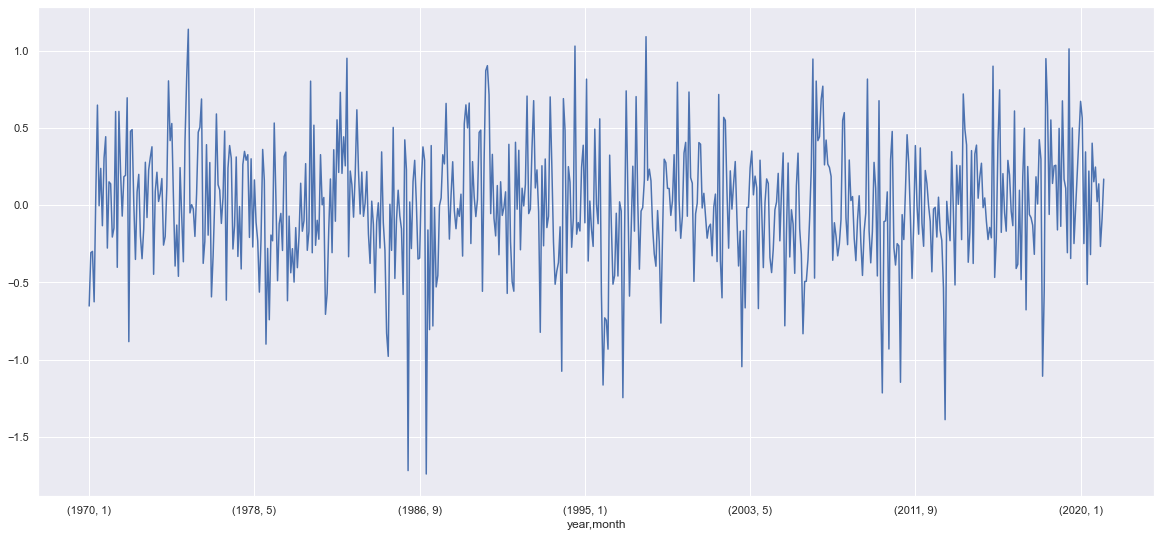

In [81]:
df_train.groupby(['year', 'month'])['residual'].mean().plot()

# Test the model

In [82]:
df_test.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,
2021-04-01,11.7,0.0,2021,4,53051,0,0,1,0,0,0,0,0,0,0,0
2021-04-02,6.1,0.0,2021,4,53052,0,0,1,0,0,0,0,0,0,0,0
2021-04-03,5.5,0.0,2021,4,53053,0,0,1,0,0,0,0,0,0,0,0
2021-04-04,5.6,0.0,2021,4,53054,0,0,1,0,0,0,0,0,0,0,0
2021-04-05,3.6,0.0,2021,4,53055,0,0,1,0,0,0,0,0,0,0,0


In [83]:
# Change & fix the time step for test data
last_train_timestep = df_train['timestep'][-1]

df_test['timestep'] = list(range(last_train_timestep + 1, 
                            last_train_timestep + len(df_test) + 1))
df_test.head()


,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,
2021-04-01,11.7,0.0,2021,4,18718,0,0,1,0,0,0,0,0,0,0,0
2021-04-02,6.1,0.0,2021,4,18719,0,0,1,0,0,0,0,0,0,0,0
2021-04-03,5.5,0.0,2021,4,18720,0,0,1,0,0,0,0,0,0,0,0
2021-04-04,5.6,0.0,2021,4,18721,0,0,1,0,0,0,0,0,0,0,0
2021-04-05,3.6,0.0,2021,4,18722,0,0,1,0,0,0,0,0,0,0,0


In [84]:
X_test = df_test.drop([ 'year', 'month', 'mean_temp', 'Q_mean_temp'],axis = 1)
y_test = df_test['mean_temp']

In [85]:
df_test['trend_seasonality'] = m_ts.predict(X_test)
df_test.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonality
DATE,,,,,,,,,,,,,,,,,
2021-04-01,11.7,0.0,2021,4,18718,0,0,1,0,0,0,0,0,0,0,0,10.427752
2021-04-02,6.1,0.0,2021,4,18719,0,0,1,0,0,0,0,0,0,0,0,10.427855
2021-04-03,5.5,0.0,2021,4,18720,0,0,1,0,0,0,0,0,0,0,0,10.427958
2021-04-04,5.6,0.0,2021,4,18721,0,0,1,0,0,0,0,0,0,0,0,10.428061
2021-04-05,3.6,0.0,2021,4,18722,0,0,1,0,0,0,0,0,0,0,0,10.428164


Text(0.5, 0, 'Date')

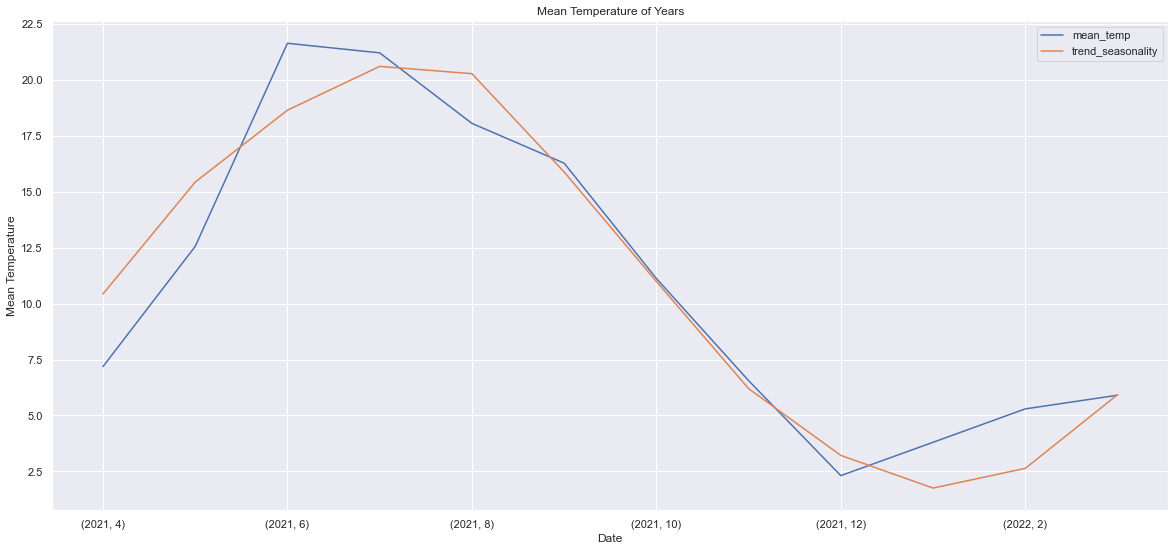

In [86]:
df_test.tail(3650).groupby(['year', 'month'])['mean_temp', 'trend_seasonality'].mean().plot()

plt.title("Mean Temperature of Years")
plt.ylabel('Mean Temperature')
plt.xlabel('Date')

In [87]:
# Calculate remainder for the test data
df_test['remainder'] = df_test ['mean_temp'] - df_test['trend_seasonality']

In [88]:
# And finally the lag for the remainder as our additional feature for the AR model.
# Create the lagged variable
df_test['lag1'] = df_test['remainder'].shift(1)

In [89]:
df_test.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonality,remainder,lag1
DATE,,,,,,,,,,,,,,,,,,,
2021-04-01,11.7,0.0,2021,4,18718,0,0,1,0,0,0,0,0,0,0,0,10.427752,1.272248,NaN
2021-04-02,6.1,0.0,2021,4,18719,0,0,1,0,0,0,0,0,0,0,0,10.427855,-4.327855,1.272248
2021-04-03,5.5,0.0,2021,4,18720,0,0,1,0,0,0,0,0,0,0,0,10.427958,-4.927958,-4.327855
2021-04-04,5.6,0.0,2021,4,18721,0,0,1,0,0,0,0,0,0,0,0,10.428061,-4.828061,-4.927958
2021-04-05,3.6,0.0,2021,4,18722,0,0,1,0,0,0,0,0,0,0,0,10.428164,-6.828164,-4.828061


In [90]:
# Assign X_test_full
X_test_full = df_test.drop([ 'year', 'month', 'mean_temp', 'Q_mean_temp', 'trend_seasonality', 'remainder'],axis = 1)

In [91]:
#Fill in the missing value from the beginning of the test lag.
X_test_full.loc['2021-04-01', 'lag1'] = df_train.loc['2021-03-31','remainder']


In [92]:
# Create the predictions
df_test['predictions_full_model'] = m_full.predict(X_test_full)

<AxesSubplot:xlabel='    DATE'>

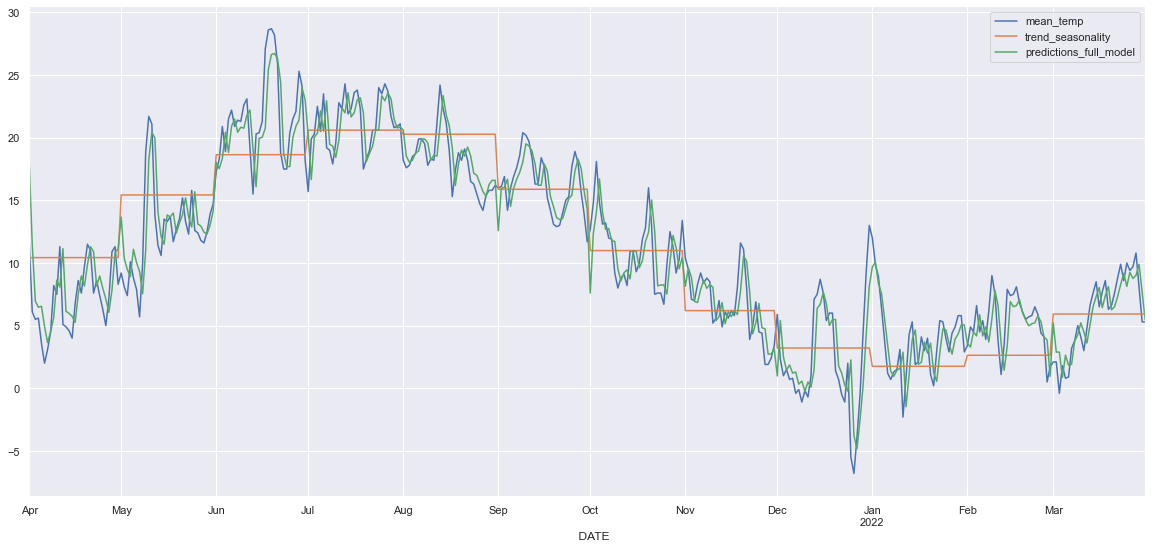

In [93]:
df_test[['mean_temp', 'trend_seasonality', 'predictions_full_model']].tail(365).plot()

In [94]:
# Create the complete dataset and plot it
df_full = df_train[['mean_temp', 'trend_seasonality', 'predictions_full_model']].append(df_test[['mean_temp', 'trend_seasonality', 'predictions_full_model']])

In [95]:
df_full.head()

,mean_temp,trend_seasonality,predictions_full_model
DATE,,,
1970-01-02,-4.9,-0.204171,-10.308888
1970-01-03,-1.4,-0.204068,-3.942538
1970-01-04,-4.4,-0.203965,-1.121992
1970-01-05,-3.0,-0.203862,-3.539566
1970-01-06,-4.7,-0.203759,-2.411336


<AxesSubplot:xlabel='    DATE,    DATE'>

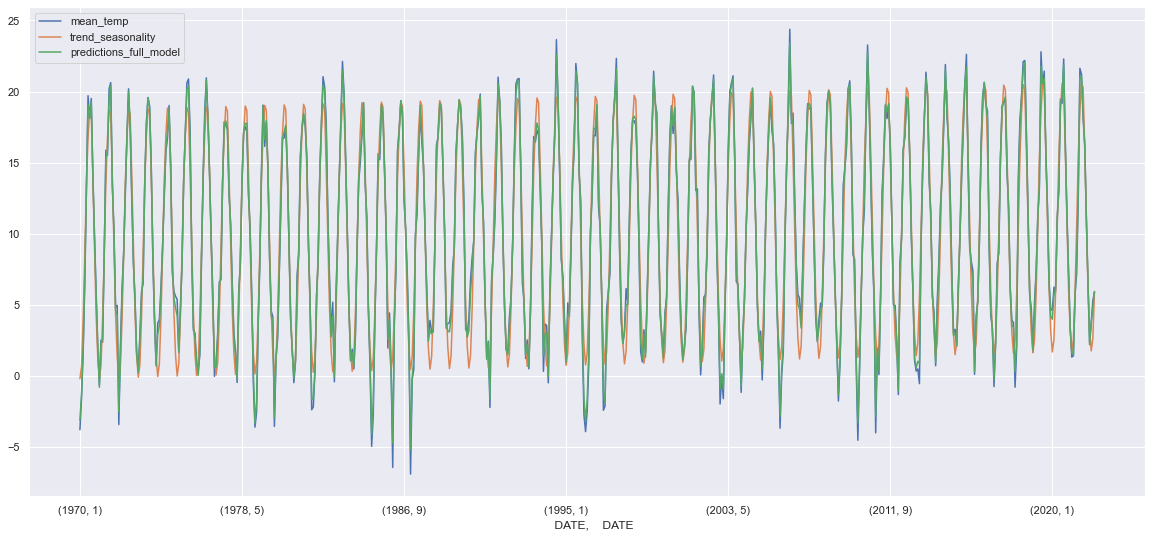

In [96]:
df_full.groupby([df_full.index.year,df_full.index.month])['mean_temp', 'trend_seasonality', 'predictions_full_model'].mean().plot()

In [97]:
print(f"""
{m_full.score(X_test_full, y_test)}
{m_ts.score(X_test, y_test)}
""")



0.9128692791826671
0.7633910898129862



# Predict the future

In [98]:
# Combine train and test data
df_train    = df_train.drop(['trend', 'wo_trend', 'trend_poly', 'wo_trend_poly', 'residual'],axis = 1)
df_combined = df_train.append(df_test)
df_combined.head()

,mean_temp,Q_mean_temp,year,month,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonality,remainder,lag1,predictions_full_model
DATE,,,,,,,,,,,,,,,,,,,,
1970-01-02,-4.9,0.0,1970,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.204171,-4.695829,-12.595726,-10.308888
1970-01-03,-1.4,0.0,1970,1,2,0,0,0,0,0,0,0,0,0,0,0,-0.204068,-1.195932,-4.695829,-3.942538
1970-01-04,-4.4,0.0,1970,1,3,0,0,0,0,0,0,0,0,0,0,0,-0.203965,-4.196035,-1.195932,-1.121992
1970-01-05,-3.0,0.0,1970,1,4,0,0,0,0,0,0,0,0,0,0,0,-0.203862,-2.796138,-4.196035,-3.539566
1970-01-06,-4.7,0.0,1970,1,5,0,0,0,0,0,0,0,0,0,0,0,-0.203759,-4.496241,-2.796138,-2.411336


In [99]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop([ 'year', 'month', 'mean_temp', 'Q_mean_temp', 'trend_seasonality', 'remainder','predictions_full_model'],axis = 1)
y_combined = df_combined['mean_temp']

In [100]:
#Fill in the missing value from the beginning of the test lag.
X_combined.loc['2021-04-01', 'lag1'] = df_train.loc['2021-03-31','remainder']

In [101]:
X_combined.isna().sum()

timestep    0
month_2     0
month_3     0
month_4     0
month_5     0
month_6     0
month_7     0
month_8     0
month_9     0
month_10    0
month_11    0
month_12    0
lag1        0
dtype: int64

In [102]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [103]:
# We are going to create a single future step data.
timestep = df_combined['timestep'].max() + 1
months   = [0] * 2 + [1] + [0] * 8
lag      = df_combined.loc['2022-03-31', 'remainder']

In [104]:
timestep, months, lag

(19083, [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], -0.6285642472808775)

In [105]:
X_future = [timestep]
X_future.extend(months)
X_future.append(lag)
X_future

[19083, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -0.6285642472808775]

In [106]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,19083,0,0,1,0,0,0,0,0,0,0,0,-0.628564


In [145]:
# Prediction for 2022-04-01
# m_full.predict(X_future) is somehow a better idea.
#m_combined.predict(X_future) , m_full.predict(X_future)
print(f' The combined model temp. predicton is {m_combined.predict(X_future)}','\n',
      f'The full model temp. predicton is {m_full.predict(X_future),}','\n',
      'The actual temp. is max 12, min 7 Celsius in a day')

 The combined model temp. predicton is [9.94646318] 
 The full model temp. predicton is (array([9.96609397]),) 
 The actual temp. is max 12, min 7 Celsius in a day


In [108]:
# One more step to the future.
timestep = df_combined['timestep'].max() + 2
months   = [0] * 2 + [1] + [0] * 8
lag      = 0

In [109]:
X_future_2 = [timestep]
X_future_2.extend(months)
X_future_2.append(lag)
X_future_2

[19084, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [110]:
X_future_2 = pd.DataFrame([X_future_2])
X_future_2.columns = X_combined.columns

X_future_2

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,19084,0,0,1,0,0,0,0,0,0,0,0,0


In [146]:
# Prediction for 2022-04-02
# m_full.predict(X_future) is somehow a better idea.
#m_combined.predict(X_future_2) , m_full.predict(X_future_2)
print(f' The combined model temp. predicton is {m_combined.predict(X_future_2)}','\n',
      f'The full model temp. predicton is {m_full.predict(X_future_2)}','\n',
      'The actual temp. is max 13, min 6 Celsius in a day')

 The combined model temp. predicton is [10.45288695] 
 The full model temp. predicton is [10.47273453] 
 The actual temp. is max 13, min 6 Celsius in a day


# Other Modelings

## Statsmodels AutoReg

In [112]:
ar_model = AutoReg(endog=df_train['remainder'], lags=1).fit()

C:\Users\X1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [113]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                18717
Model:                     AutoReg(1)   Log Likelihood              -42322.216
Method:               Conditional MLE   S.D. of innovations              2.322
Date:                Mon, 02 May 2022   AIC                              1.685
Time:                        10:01:40   BIC                              1.686
Sample:                    01-03-1970   HQIC                             1.685
                         - 03-31-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0008      0.017      0.047      0.963      -0.032       0.034
remainder.L1     0.8060      0.004    186.228      0.000       0.798       0.814
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2407           +0.0000j            1.2407            0.0000
-----------------------------------------------------------------------------
"""

In [114]:
df_train['predictions_ar'] = ar_model.predict()

<AxesSubplot:xlabel='year,month'>

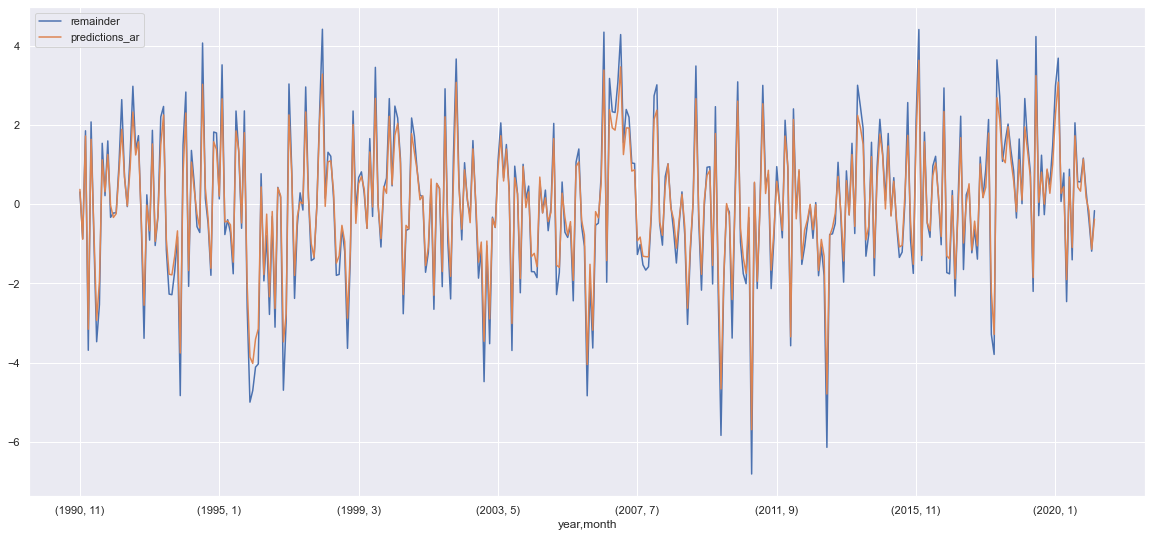

In [115]:
df_train.groupby(['year', 'month'])['remainder', 'predictions_ar'].mean().tail(365).plot()

In [116]:
df_train.dropna(inplace = True)

In [117]:
df_train['full_pred_ar'] = df_train['trend_seasonality'] + df_train['predictions_ar']

<AxesSubplot:xlabel='year,month'>

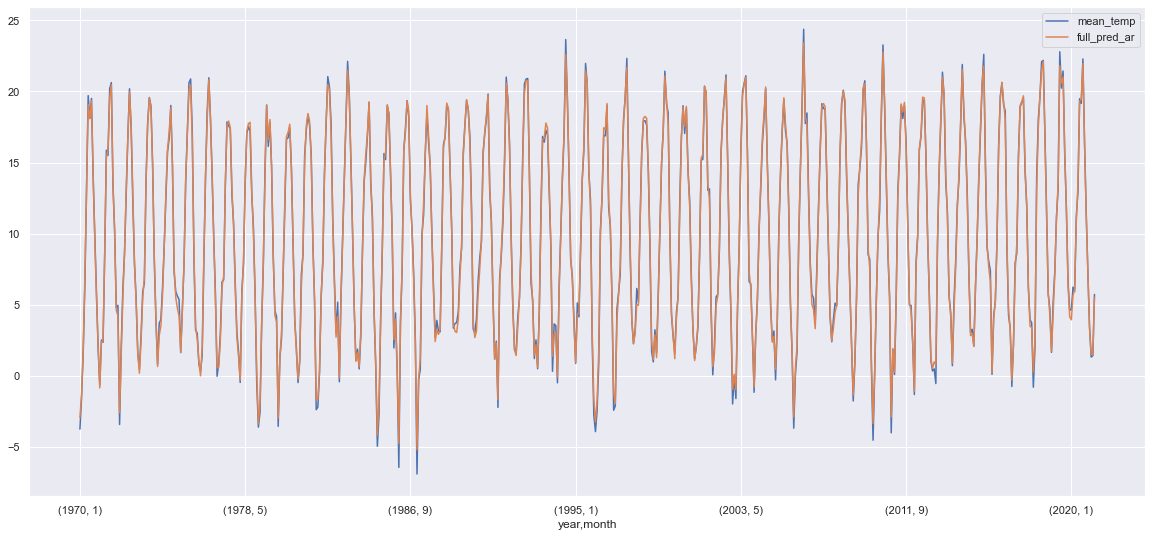

In [118]:
df_train.groupby(['year', 'month'])['mean_temp', 'full_pred_ar'].mean().tail(3650).plot()

## ARIMA - Autoregressive Integrated Moving Average

In [119]:
# Instead of using past values of the variable itself we will use past prediction errors to predict the future

In [120]:
from statsmodels.tsa.arima.model import ARIMA

In [121]:
arima = ARIMA(endog= df_train['remainder'], order = (1,0,3)).fit()

C:\Users\X1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\X1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\X1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [122]:
'''p - AR part (regression on the X data, 0 to 3) - FIRST (HYPER) PARAMETER
d - I (0 or 1) - SECOND (HYPER) PARAMETER
q - MA (of the residuals!!, 0 to 3) = THIRD (HYPER) PARAMETER'''

'p - AR part (regression on the X data, 0 to 3) - FIRST (HYPER) PARAMETER\nd - I (0 or 1) - SECOND (HYPER) PARAMETER\nq - MA (of the residuals!!, 0 to 3) = THIRD (HYPER) PARAMETER'

In [123]:
df_train['arima_prediction'] = arima.predict()

<AxesSubplot:xlabel='year,month'>

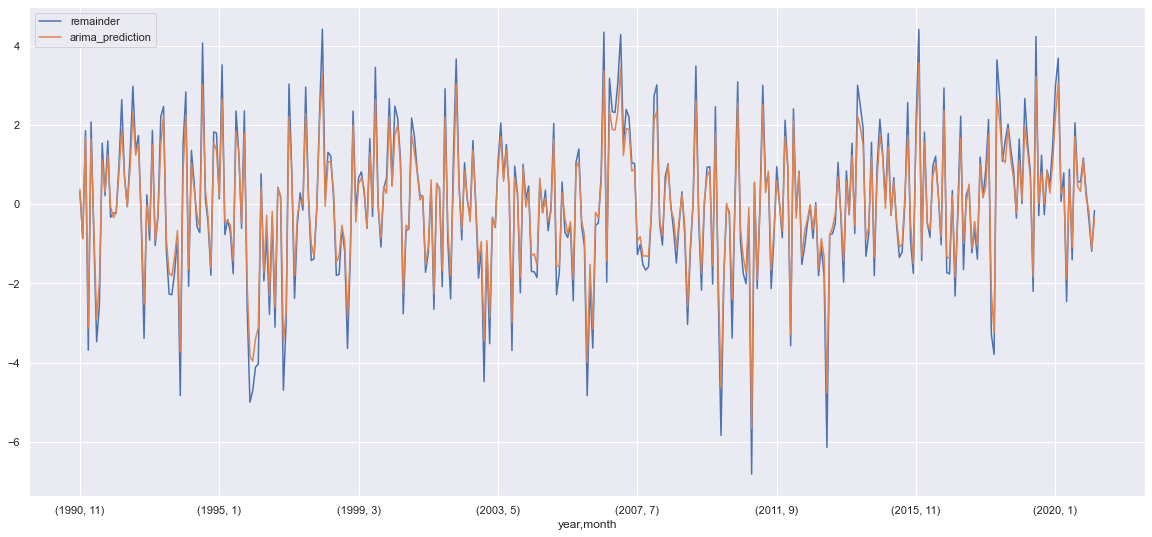

In [124]:
df_train.groupby(['year', 'month'])['remainder', 'arima_prediction'].mean().tail(365).plot()

<AxesSubplot:xlabel='year,month'>

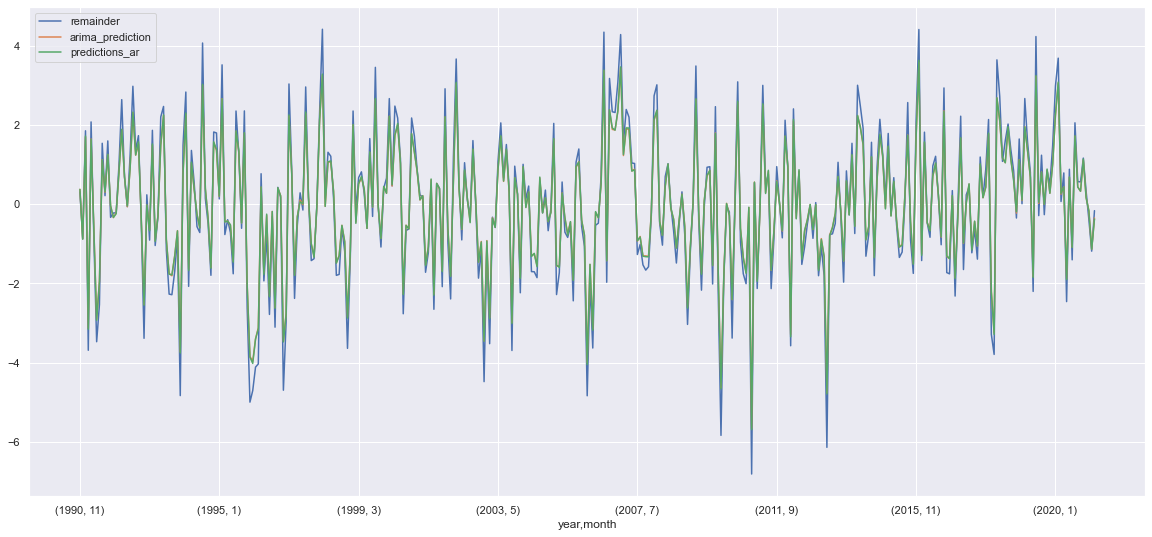

In [125]:
df_train.groupby(['year', 'month'])['remainder', 'arima_prediction', 'predictions_ar'].mean().tail(365).plot()

In [126]:
# some kind of evaluating metric to check

In [127]:
from sklearn.metrics import mean_absolute_error

In [128]:
ar_error = round(mean_absolute_error(df_train['remainder'], df_train['predictions_ar']),2)
arima_error = round(mean_absolute_error(df_train['remainder'], df_train['arima_prediction']),2)

In [129]:
f'Mean absolute error for Auto Regression: {ar_error} and it was improved to {arima_error} with ARIMA'

'Mean absolute error for Auto Regression: 1.81 and it was improved to 1.78 with ARIMA'

In [130]:
### For the full passengers and talking about real passengers
df_train['full_pred_arima'] = df_train['trend_seasonality']+ df_train['arima_prediction']

In [131]:
base_model_error = round(mean_absolute_error(df_train['mean_temp'], df_train['trend_seasonality']),2)
ar_error = round(mean_absolute_error(df_train['mean_temp'], df_train['full_pred_ar']),2)
arima_error = round(mean_absolute_error(df_train['mean_temp'], df_train['full_pred_arima']),2)

In [132]:
f'Mean absolute error for the base model {base_model_error}, the  Auto Regression: {ar_error} and  ARIMA {arima_error}'

'Mean absolute error for the base model 3.13, the  Auto Regression: 1.81 and  ARIMA 1.78'